In [1]:
%load_ext autoreload
% autoreload 2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='serif')


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from geant_dataloader import rtnpy_load_data
from logistics import *
import random
import datetime
import os

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (8.0, 8.0)
print(torch.__version__)

0.4.0a0+200fb22


In [2]:
#currently only performs on 32 x 32 image size



torch.manual_seed(423312)
imageSize = 32
batchSize = 32
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
norm_scale = 'unif'
epoch=0 #will be updated during the run
num_epochs = 30
nc =1
ndf = 64
ngf = 64
nz = 6

In [3]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
    
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        

('Random Seed: ', 25)
Using Cuda
cuda:1
('Using:', 'gpu', 0L)


In [36]:
#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", num_events = 100, image_size = imageSize)
image_array1 = rtnpy_load_data("numpy_data/rebinnedGeant4Data_15000Events_64OldSize_32NewSize.npz", image_size = imageSize)
image_array2 = rtnpy_load_data("numpy_data/geant4Data_30000Events_32ImageSize_800MeV_ScintiAbsoThickness75_8.npz", image_size = imageSize)
image_array=np.concatenate((image_array1, image_array2),0)

np.savez_compressed("numpy_data/rebinnedGeant4Data_15000Events_64OldSize_32NewSize.npz", array = image_array1)

In [5]:

print image_array.shape


(44992, 1, 32, 32)


In [6]:
#print norm_scale
normed_array, scale = normalize(image_array, norm_scale = norm_scale )

tensor_array_train = torch.stack([torch.Tensor(i) for i in normed_array[:30000]])
tensor_data_train = torch.utils.data.TensorDataset(tensor_array_train)
tensor_array_test = torch.stack([torch.Tensor(i) for i in normed_array[30000:]])
tensor_data_test = torch.utils.data.TensorDataset(tensor_array_test)

train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size=batchSize, num_workers=8)
test_loader = torch.utils.data.DataLoader(tensor_data_test, batch_size = batchSize, num_workers = 8)
print(train_loader)

In [12]:
def to_img(x, norm_scale = norm_scale, scale = scale):
    x = x.cpu().data.numpy()
    #x = 0.5 * (x + 1)
   # print x
   # x = np.clip(x, 0, 1)
    
    # this just drops the channel axis
    x = x.reshape([-1, 32, 32])

    x = unnormalize(x, scale = scale, norm_scale = norm_scale)
    #print x.max()
    
    return x

def plot_reconstructions(model, save_dir=None, epoch = epoch, n_events = num_epochs, latent_dim = nz, conv=True, simple=False, n=4, norm_scale = norm_scale, batchSize = batchSize, scale = scale):
    """
    Plot 10 reconstructions from the test set. The top row is the original
    digits, the bottom is the decoder reconstruction.
    """
    # encode then decode
    data= next(iter(test_loader))
 
    if not conv:
        data = data.view([-1, 4096])

    true_imgs = data[0]
    encoded_imgs = model.encoder(data[0].to(device))
    if simple:
        encoded_imgs = F.relu(encoded_imgs)
  
    decoded_imgs = model.decoder(encoded_imgs)

    true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
    decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)
    print(decoded_imgs.shape)
    
    rowsize = n * 2.5
    columnsize = 4
    fig, axn = plt.subplots(figsize=(rowsize, columnsize))
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.98, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        #print(true_imgs[i].max())
        if i == 0:
            im = plt.imshow(true_imgs[i], cmap=cmap)
        else: 
            plt.imshow(true_imgs[i], cmap=cmap)
        #if i == 0:
        #    ax.set_ylabel("Real")
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        if i == 0:
            ax.set_ylabel("Real", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.25,0.5)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i], cmap=cmap)
        print(decoded_imgs[i].min(), decoded_imgs[i][0].max())
        if i == 0:
            ax.set_ylabel("Decoded", rotation  = 0, fontsize = 13)
            ax.yaxis.set_label_coords(-.3,0.5)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.set_yticklabels([])
        ax.yaxis.set_ticks_position('none') 
        

    plt.tight_layout()

    cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    fig.subplots_adjust(wspace=-0.185, hspace=0.09)
    fig.suptitle(r"DCVAE Real and Decoded Samples of $e^{-}$ $E_{dep}$, "+ str(latent_dim) + " Latent Dim ", x=0.52, y = 1.02)
          
    if save_dir != None:
        #learning_rate = '%.0E' % Decimal(lr)
      
        filename = "DCVAE_EdepFor" + str(n_events) + "Events_" + str(latent_dim) +"latentDim_"+ str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize"
        #print(save_dir)
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    
    return

In [28]:

nz = 10
class  ConvolutionalAutoEncoder(nn.Module):
    def __init__(self,ngpu):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.ngpu = ngpu
        
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, ndf, 4,  2, 1),
            nn.MaxPool2d(3,stride=2),
            nn.ReLU(True),
            nn.Conv2d(ndf, nz, 4, 1 , 0),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)

        )
        
#         nn.ConvTranspose2d(16, 16, 2, stride=3, padding=0),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 8, 2, stride=2, padding=1),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=0),
#             nn.Tanh(),
        self.decoder = nn.Sequential(
            
            # input is encoder final size ( height, width = 6 in this case), going into a convolution transpose
            nn.ConvTranspose2d( nz, ngf * 8, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            #nn.ReLU(True),
            # state size. (ngf*8) x 14 x 14
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 17 x 17
            nn.ConvTranspose2d(ngf * 4, ngf *2 , 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 33 x 33
            nn.ConvTranspose2d(ngf * 2,     nc, 4, 2, 2, bias=False),
            #nn.BatchNorm2d(nc),
            nn.Sigmoid(),
            # state size. (ngf) x x 32
            #nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            #nn.ReLU(inplace=True)
            #last_layer
    
        )
    def forward(self, x):
        #x = x.view(-1,1,64,64)
        if x.is_cuda and self.ngpu > 1:
            x = nn.parallel.data_parallel(self.encoder, x, range(self.ngpu))
            x = nn.parallel.data_parallel(self.decoder, x, range(self.ngpu))
        else:
            x = self.encoder(x)
            x = self.decoder(x)
        return x
    

class  ConvolutionalAutoEncoder2(nn.Module):
    def __init__(self,ngpu):
        super(ConvolutionalAutoEncoder2, self).__init__()
        self.ngpu = ngpu
        
        self.encoder = nn.Sequential(
                #input 64 x 64
            nn.Conv2d(1, 32, 4, 2, 1), # 32 x 32
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 4, 2, 1),  # 16 x 16
            nn.BatchNorm2d(32),
            #nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1) , # 8 x 8
            nn.BatchNorm2d(64),
            #nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),  # 4 x 4
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 512, 4),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, nz, 1),
            # setup the non-linearity
            nn.ReLU(inplace=True)
        )
                
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(nz, 512, 1, 1, 0),  # 1 x 1
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 64, 4, 1, 0) , # 4 x 4
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 4, 2, 1),  # 8 x 8
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, 2, 1) , # 16 x 16
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),  # 32 x 32
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            # setup the non-linearity
            nn.Sigmoid()
        )
        
    def forward(self, x):
        #x = x.view(-1,1,64,64)
        if x.is_cuda and self.ngpu > 1:
            x = nn.parallel.data_parallel(self.encoder, x, range(self.ngpu))
            x = nn.parallel.data_parallel(self.decoder, x, range(self.ngpu))
        else:
            x = self.encoder(x)
            x = self.decoder(x)
        return x
    
    

class  ConvolutionalAutoEncoder32(nn.Module):
    def __init__(self,ngpu):
        super(ConvolutionalAutoEncoder32, self).__init__()
        self.ngpu = ngpu
        
        self.encoder = nn.Sequential(
                #input 64 x 64
            #nn.Conv2d(1, 32, 4, 2, 1), # 32 x 32
            #nn.BatchNorm2d(32),
            nn.Conv2d(1, 32, 5, 2, 1),  # 16 x 16
            nn.BatchNorm2d(32),
            #nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1) , # 8 x 8
            nn.BatchNorm2d(64),
            #nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1, 1),  # 4 x 4
            nn.BatchNorm2d(256),
            nn.Conv2d(256, nz, 3,1,1),
            #nn.BatchNorm2d(256),
           # nn.Conv2d(256, 10, 1),
            # setup the non-linearity
            nn.ReLU(inplace=True)
        )
                
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(nz, 256, 1, 1, 0),  # 1 x 1
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 64, 4, 2, 0) , # 4 x 4
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 5, 2, 1),  # 8 x 8
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, 4, 1, 0) , # 16 x 16
            #nn.BatchNorm2d(32),
            #nn.ConvTranspose2d(32, 1, 1, 2, 1),  # 32 x 32
            #nn.BatchNorm2d(32),
            #nn.ConvTranspose2d(32, 1, 4, 2, 1),
            # setup the non-linearity
            nn.ReLU()
        )
        
    def forward(self, x):
        #x = x.view(-1,1,64,64)
        if x.is_cuda and self.ngpu > 1:
            x = nn.parallel.data_parallel(self.encoder, x, range(self.ngpu))
            x = nn.parallel.data_parallel(self.decoder, x, range(self.ngpu))
        else:
            x = self.encoder(x)
            x = self.decoder(x)
        return x

In [29]:
model = ConvolutionalAutoEncoder32(ngpu).to(device)
optimizer = optim.Adam(model.parameters())

In [30]:
def train(epoch):
    for batch_idx, data in enumerate(train_loader,0):
        data = data[0].to(device)
        #print(data.shape)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss -= F.binary_cross_entropy_with_logits(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [ ]:

mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/ConVAE/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

with open(mydir + 'NetworkInfo.txt', 'w') as f:
    print >> f, 'model:', model
    

for epoch in range(1,  num_epochs + 1):
    plot_reconstructions(model, save_dir=mydir, n=6, conv=True, epoch = epoch, simple=False)
    train(epoch)

(32, 32, 32)
(45.774147, 46.276417)
(45.70729, 46.273777)
(44.876877, 46.275337)
(45.79074, 46.2707)
(45.3177, 46.267853)


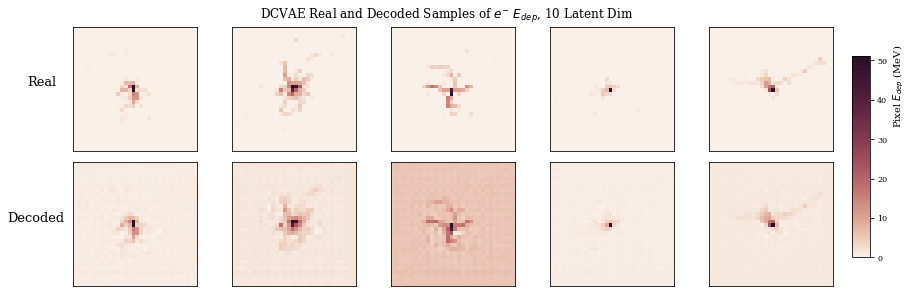

In [27]:
plot_reconstructions(model, save_dir=None, conv=True, simple=False, n=5)

In [ ]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/ConVAE/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [ ]:
data= next(iter(test_loader))
#print(data[0].shape)
#print norm_scale

#data = Variable(data, volatile=True)
true_imgs = data[0]
encoded_imgs = model.encoder(data[0].to(device))
#if simple:
#    encoded_imgs = F.relu(encoded_imgs)
decoded_imgs = model.decoder(encoded_imgs)
#print(decoded_imgs)
true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)

In [ ]:
plt.figure(figsize= (10,10))
im = plt.imshow(true_imgs[2] - decoded_imgs[2])
plt.colorbar(im)

In [ ]:
combined_fake_image = 0
for i in range(len(decoded_imgs)):
    combined_fake_image += decoded_imgs[i]
combined_fake_image = combined_fake_image / len(true_imgs)

combined_real_image = 0
for i in range(len(true_imgs)):
    combined_real_image += true_imgs[i]
combined_real_image = combined_real_image / len(true_imgs) - 28

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(combined_real_image, cmap ='PuOr')
plt.colorbar(im)

(32, 32, 32)


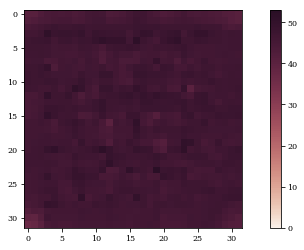

In [363]:
# nz = 10
# data = torch.FloatTensor(np.random.uniform(low=0,high=20,size= (batchSize,nz,6,6))).to(device)
# #data = torch.randn(batchSize,nz,6,6).to(device)
# #print(data)
                 
# decoded_imgs = unnormalize(model.decoder(data).cpu().data.numpy().reshape([-1,32,32]),scale=scale,norm_scale=norm_scale)
# #print(decoded_imgs)
# #true_imgs = to_img(true_imgs, norm_scale = norm_scale,  scale = scale)
# #decoded_imgs = to_img(decoded_imgs, norm_scale = norm_scale, scale = scale)
# print(decoded_imgs.shape)

# n=4
# rowsize = n * 2.5
# columnsize = 4

# fig, ax = plt.subplots(figsize=(rowsize, columnsize))
# cmap = sns.cubehelix_palette(dark = 0.4, light=0.98, gamma = 2.5, hue = 1, start =0, as_cmap=True)
# im = ax.imshow(decoded_imgs[0], cmap=cmap, vmin=0)
# plt.colorbar(im)
